In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import lzma

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def load_data(file):
    with lzma.open(file, mode='rt') as f:
        records = []
        for line in f.readlines():
            r = {}
            try:
                r['iteration'] = int(line[:4])
                r['rec_num'] = int(line[4:11])
                date = datetime.datetime.strptime(
                    line[11:37], '  %d %b %Y %H:%M:%S.%f')
                r['date'] = np.datetime64(date)
                r['obs'] = line[39:59].strip()
                r['participants'] = line[59:84].strip()
                r['edit'] = line[84:98].strip()
                r['observed'] = float(line[98:120])
                r['computed'] = float(line[120:139])
                r['residual'] = float(line[139:155])
                elev = line[155:159].strip()
                r['elev'] = float(elev) if elev else np.nan
            except ValueError:
                pass
            else:
                records.append(r)

    data = np.array(
        [(r['iteration'], r['rec_num'], r['date'], r['obs'], r['participants'],
          r['edit'], r['observed'], r['computed'], r['residual'], r['elev'])
         for r in records],
        dtype=[('iteration', 'u4'), ('rec_num', 'u4'), ('date', 'M8[us]'),
               ('obs', 'U20'), ('participants', 'U25'), ('edit', 'U14'),
               ('observed', 'f8'), ('computed', 'f8'), ('residual', 'f8'),
               ('elev', 'f4')]
    )
    return data

In [3]:
def make_plots(data, fig=None, axs=None, tw=None):
    last_iter = data[-1]['iteration']
    sel = (data['iteration'] == last_iter) & (data['obs'] == 'RangeRate')
    seledit = sel & (data['edit'] == '')
    selused = sel & (data['edit'] != '')
    if fig is None:
        fig, axs = plt.subplots(2, 1, figsize=(7.5, 6), sharex=True)
    axs[0].plot(data[seledit]['date'], data[seledit]['residual']*1e6, '.')
    axs[0].plot(data[selused]['date'], data[selused]['residual']*1e6, '.')
    axs[0].set_ylabel('Range-rate\nresidual (mm/s)')
    axs[0].set_ylim((-100, 100))
    gps_comp = data[(data['iteration'] == last_iter) & (data['obs'] == 'GPS_PosVec')]['computed'].reshape(-1, 3)
    time_gps = data[(data['iteration'] == last_iter) & (data['obs'] == 'GPS_PosVec')]['date'][::3]
    long = np.rad2deg(np.angle(gps_comp[:, 0] + 1j * gps_comp[:, 1]))
    radius = np.sqrt(np.sum(gps_comp**2, axis=1))
    geo_radius = 42164
    axs[1].plot(time_gps, radius - geo_radius, label='r')
    axs[1].plot(time_gps, gps_comp[:, 2], label='z')
    axs[1].set_ylabel('r: Radius - GEO\nz: ECEF Z (km)')
    axs[1].set_xlabel('UTC time')
    plt.xticks(rotation=45)
    if tw is None:
        tw = axs[1].twinx()
    tw.plot(time_gps, long)#, color='C2')
    tw.set_ylabel('Longitude (deg)', color='C2')
    axs[1].legend()
    plt.subplots_adjust(hspace=0.05)
    return fig, axs, tw

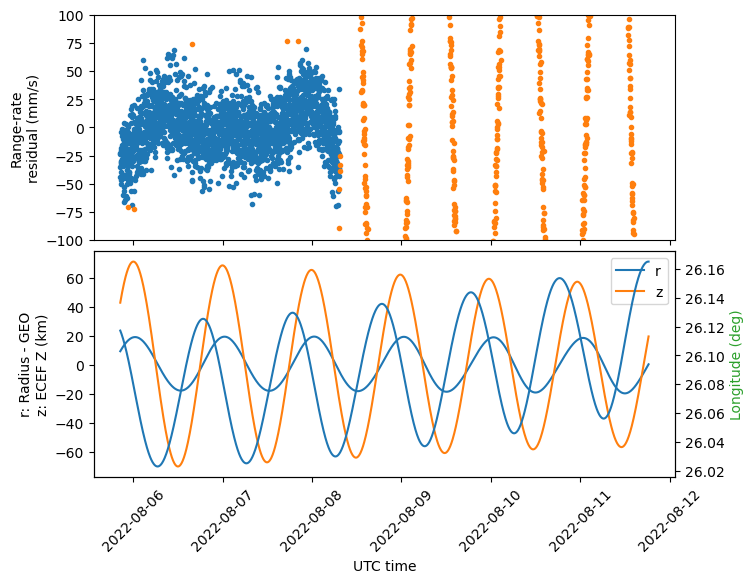

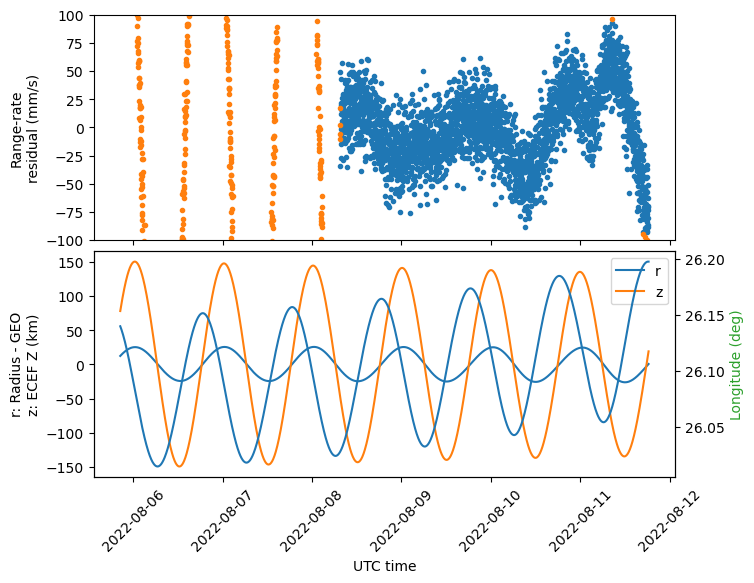

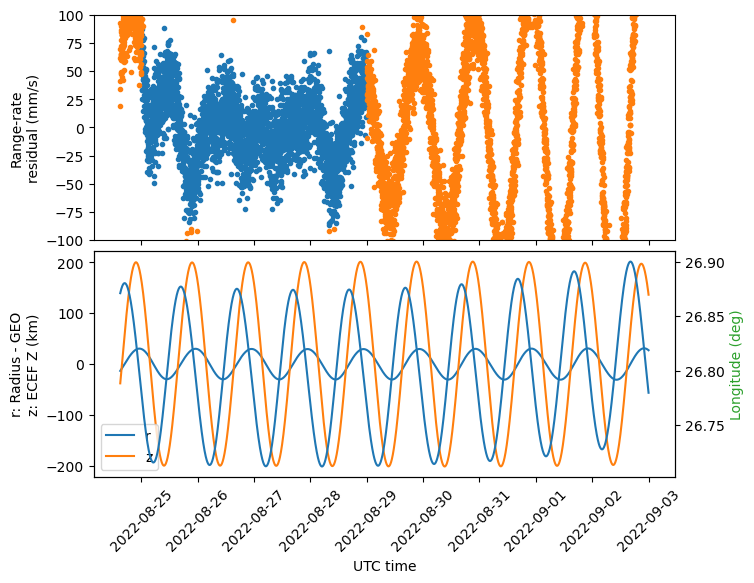

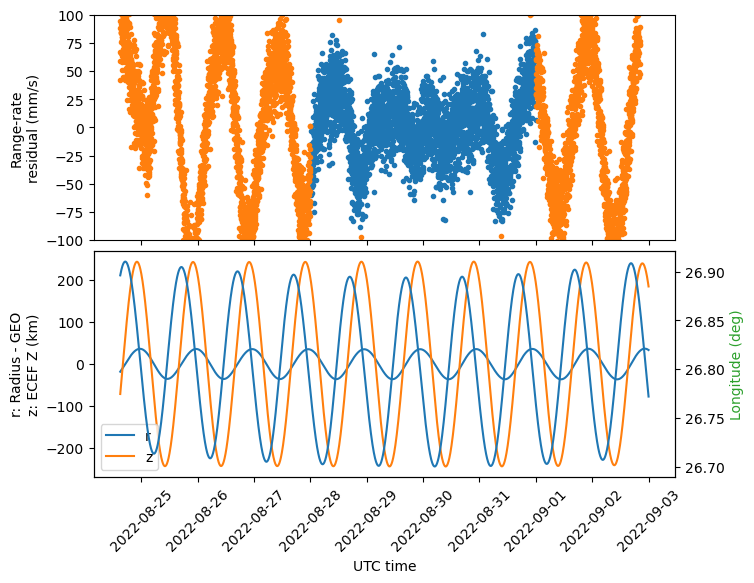

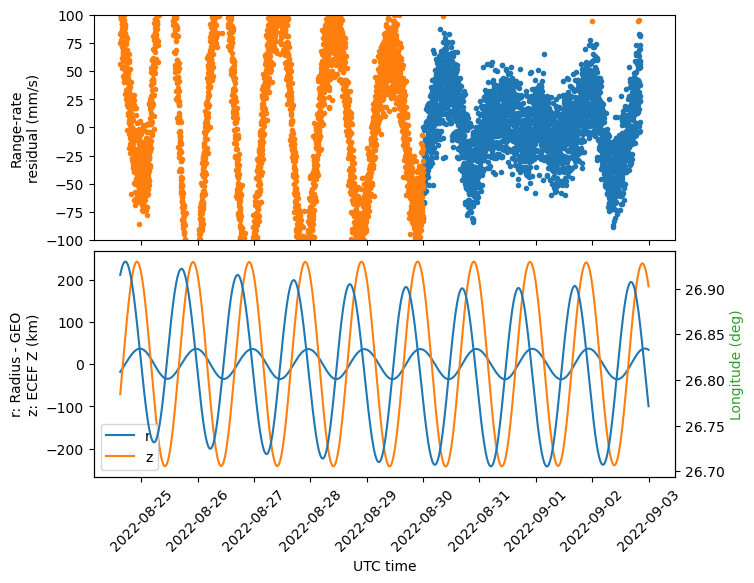

In [4]:
for file in ['qo100_29797_before_stationkeeping.report.xz',
             'qo100_29797_after_stationkeeping.report.xz',
             'qo100_29816_20220825_20220829.report.xz',
             'qo100_29816_20220828_20220901.report.xz',
             'qo100_29816_20220830_20220903.report.xz']:
    make_plots(load_data(file))